In [1]:
from dolphin.phase_link import simulate, covariance, _core
import numpy as np
import matplotlib.pyplot as plt
from dolphin import Strides, HalfWindow

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set up a simulate stack of deformation with correlated noise

In [19]:
num_time, *shape2d = 30, 128, 128
num_pixels = np.prod(shape2d)

C, _ = simulate.simulate_coh(num_time)
defo_stack = simulate.make_defo_stack((num_time, *shape2d), sigma=20, max_amplitude=10)
defo_phase = np.exp(1j * defo_stack)


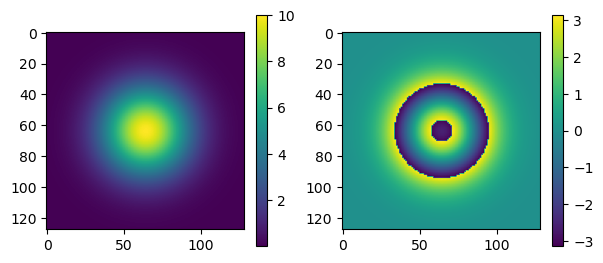

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
axim = axes[0].imshow(defo_stack[-1])
fig.colorbar(axim, ax=axes[0])

axim = axes[1].imshow(np.angle(defo_phase[-1]))
fig.colorbar(axim, ax=axes[1])

In [21]:
samps3d = simulate.create_noisy_deformation(C, defo_stack)

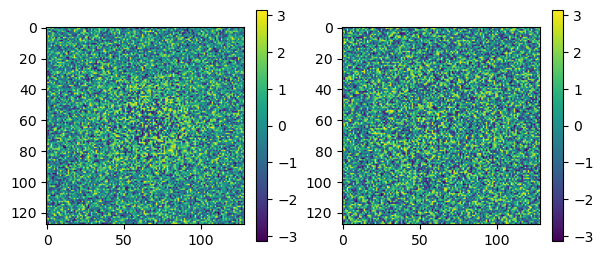

In [22]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))

img1 = np.angle(samps3d[0].conj() * samps3d[10])
img2 = np.angle(samps3d[0].conj() * samps3d[-1])

for ax, img in zip(axes, [img1, img2]):
    axim = ax.imshow(img)
    fig.colorbar(axim, ax=ax)


## Run phase linking on the simulated stack to recover the deformation

In [23]:
strides = Strides(1, 1)
half_window = HalfWindow(5, 5)

### Run the EMI algorithm

CPU times: user 8.05 s, sys: 612 ms, total: 8.66 s
Wall time: 6.56 s


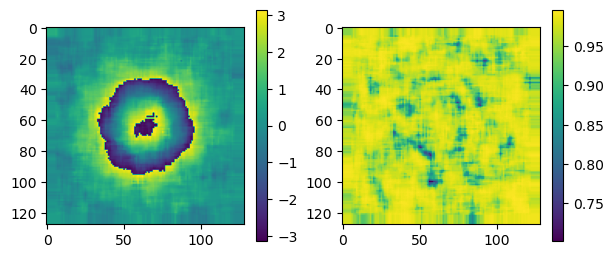

In [24]:
%%time
pl_out_emi = _core.run_phase_linking(samps3d, half_window=half_window, strides=strides)

fig, axes = plt.subplots(ncols=2, figsize=(7, 3))


for ax, img in zip(axes, [np.angle(pl_out_emi.cpx_phase[-1]), pl_out_emi.temp_coh]):
    axim = ax.imshow(img)
    fig.colorbar(axim, ax=ax)


### Run the EVD algorithm

CPU times: user 2.26 s, sys: 427 ms, total: 2.69 s
Wall time: 1.9 s


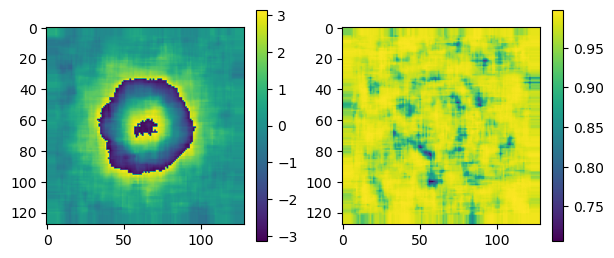

In [25]:
%%time
pl_out_evd = _core.run_phase_linking(samps3d, half_window=half_window, strides=strides, use_evd=True)

fig, axes = plt.subplots(ncols=2, figsize=(7, 3))

for ax, img in zip(axes, [np.angle(pl_out_evd.cpx_phase[-1]), pl_out_evd.temp_coh]):
    axim = ax.imshow(img)
    fig.colorbar(axim, ax=ax)


## Check the RMSE of the stacks

In [26]:
np.angle(defo_phase * pl_out_evd.cpx_phase).sum(axis=(1, 2))


array([-7.0873648e-04,  1.4923295e+03,  3.1915015e+03,  4.8797012e+03,
        6.4893955e+03,  7.1140439e+03,  5.5896328e+03,  5.1101396e+03,
        4.7096245e+03,  4.4325732e+03,  4.2781318e+03,  4.3200391e+03,
        4.4938354e+03,  4.8549443e+03,  5.3488994e+03,  5.1444629e+03,
        5.0877998e+03,  4.9664614e+03,  5.0045850e+03,  5.1996377e+03,
        5.4429355e+03,  5.7011978e+03,  6.0210234e+03,  6.2125977e+03,
        6.0467949e+03,  5.6307905e+03,  5.3487793e+03,  5.2226045e+03,
        5.3120342e+03,  5.1866558e+03], dtype=float32)

In [27]:
np.angle(defo_phase * pl_out_emi.cpx_phase).sum(axis=(1, 2))


array([-4.2959556e-04,  1.6257500e+03,  3.3642324e+03,  5.0356270e+03,
        6.7051152e+03,  7.1783789e+03,  5.6954082e+03,  5.0574297e+03,
        4.6423262e+03,  4.5086816e+03,  4.3363809e+03,  4.4830283e+03,
        4.6169590e+03,  5.1380708e+03,  5.5722012e+03,  5.3054092e+03,
        5.2791313e+03,  5.1266626e+03,  5.2122607e+03,  5.3545259e+03,
        5.5932686e+03,  5.8181631e+03,  6.1074678e+03,  6.2494780e+03,
        5.9446328e+03,  5.7215186e+03,  5.3900898e+03,  5.1553374e+03,
        5.2020273e+03,  5.2107495e+03], dtype=float32)

In [28]:
simulate.rmse(defo_phase, pl_out_evd.cpx_phase)

0.22695433

In [29]:
simulate.rmse(defo_phase, pl_out_emi.cpx_phase)

0.20756909